In [3]:
import pandas as pd
import os
import datetime
import nltk 
import re
import numpy as np
import gensim
import pickle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Note: You will need to install the packages below to use them
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Step 1: Data Cleaning
##### You can go straight to the second last section in Step 1 if you prefer to use the pickle file that has already been created

## Importing Data

In [ ]:
#Write your directory for the data file here

#data_dir = 'C:/Users/owzhe/Downloads/14-million-cell-phone-reviews/'
data_dir = 'C:/Users/Eugene/Desktop/Modules/Text Mining and Language Processing (IS450)/Project/Potential datasets/14-million-cell-phone-reviews/'

In [ ]:
reviews_files = os.listdir(data_dir)

reviews_df = pd.DataFrame()

for file in reviews_files:
    current = pd.read_csv(data_dir + file, encoding = "ISO-8859-1")
    reviews_df = reviews_df.append(current)
    

In [ ]:
print(len(reviews_df))
reviews_df.head()

## EDA

In [ ]:
# Taking only the reviews that are in english
reviews_en_df = reviews_df[reviews_df['lang'] == 'en']
print(len(reviews_en_df))
reviews_en_df.head()

In [ ]:
print(len(reviews_en_df['phone_url'].unique()))
print(reviews_en_df['phone_url'].unique())

In [ ]:
# Creating the function to return the phone model from the URL
def phone_model(url):
    phone_type = ' '.join(url[12:-1].split('-')).title()
    return phone_type

In [ ]:
# Applying the phone_model function on the url 
reviews_en_df['phone_model'] = reviews_en_df['phone_url'].apply(phone_model)

In [ ]:
print(len(reviews_en_df['phone_model'].unique()))

In [ ]:
# Creating another copy of the reviews_df
reviews_copy_df = reviews_en_df.copy()

In [ ]:
# Found out that the dates are abit off - majority are in month/day/year but there is around 20k that is day/month/year
def check_date(row_date):
    month, day, year = row_date.split('/')
    isValid = True
    try:
        datetime.datetime(int(year), int(month), int(day))
    except:
        isValid = False
    
    return isValid

In [ ]:
# Creating a year column
def review_year(row_date):
    month, day, year = row_date.split('/')

    return year

In [ ]:
reviews_copy_df['date_check'] = reviews_copy_df['date'].apply(check_date)
reviews_copy_df['year'] = reviews_copy_df['date'].apply(review_year)
reviews_copy_df.head()

In [ ]:
# Checking the number of wrong and correct dates 
wrong_dates = reviews_copy_df[reviews_copy_df['date_check'] == False]
print('No. of wrong dates:', len(wrong_dates))

correct_dates = reviews_copy_df[reviews_copy_df['date_check'] == True]
print('No. of correct dates:', len(correct_dates))

In [ ]:
# Created a function to clean the date for the incorrect date format
def clean_date(date):
    month, day, year = date.split('/')
    return '/'.join([day, month, year])

#     for index, row in reviews_df.iterrows():
#         month, day, year = row['date'].split('/')
#         if row['date_check'] == False:
#             reviews_df.loc[index, 'date'] = '/'.join([day, month, year])
#             row['date_check'] = True
#     return reviews_df

In [ ]:
# Clean up the date format of the dataframe with wrong dates
wrong_dates['date'] = wrong_dates['date'].apply(clean_date)
wrong_dates

In [ ]:
# Returning the cleaned dataframe use for analysis 
cleaned_df = correct_dates.append(wrong_dates, ignore_index=True)
cleaned_df = cleaned_df[cleaned_df['year'].astype(int) >= 2013]
cleaned_df.drop(columns=['phone_url', 'date_check', 'year'], inplace=True)

In [ ]:
# Checking null rows
null_columns = cleaned_df.columns[cleaned_df.isna().any()]
cleaned_df[null_columns].isna().sum()

In [ ]:
cleaned_df.dropna(subset=['extract'], inplace=True)
len(cleaned_df)

## Storing/Opening pickle file for the cleaned dataframe 

In [71]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE CLEANED DATAFRAME FROM ABOVE @@@@@@@@@###
# pickle.dump(cleaned_df, open("cleaned_reviews_df.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE CLEANED DATAFRAME FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#cleaned_df = pickle.load(open("C:/Users/owzhe/OneDrive/Documents/GitHub/phone-reviews-analysis/Pickle Files/cleaned_reviews_df.pkl", "rb"))
cleaned_df = pickle.load(open("C:/TextAnalytics/GroupProject/Pickle Files/cleaned_reviews_df.pkl", "rb")) #sam's

## Preparation for Modelling

In [72]:
cleaned_df.head()

,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model
0,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,"As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far. I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced. The battery life is amazing.",CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8
1,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth and beautiful I highly recommend the phone you will not regret getting this phone.,james0923,Samsung Galaxy S8,Samsung Galaxy S8
2,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sluggish for the few apps that I have installed. Samsung wants to vacuum all of your data with their apps that requires more access than needed. What else is new.,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unlocked (GSM + CDMA, US WARRANTY) (Orchid Gray)",Samsung Galaxy S8
3,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,"Never disappointed. One of the reasons I've been a long Samsung (product) consumer, they're ability to impress me with each product release. I've owned, or maintained, all Samsung smartphones starting with the S4 and the S8 is the best one yet.",Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8
4,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people that have carried their phone in their pocket without problems until the S8. Day one screen has crack from being in my pocket. Bluetooth on my 1st trip struggles to stay connected. Good news.....battery life is great and lots of great features.,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8


In [6]:
## Create an index series to find back the actual extract later on
import numpy as np
import pandas as pd

data_len = len(cleaned_df)
index_series = np.arange(data_len)

cleaned_df['index'] = index_series

cleaned_df

,date,lang,country,source,domain,score,score_max,extract,author,product,phone_model,index
0,5/2/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,As a diehard Samsung fan who has had every Sam...,CarolAnn35,Samsung Galaxy S8,Samsung Galaxy S8,0
1,4/28/2017,en,us,Phone Arena,phonearena.com,10.0,10.0,Love the phone. the phone is sleek and smooth ...,james0923,Samsung Galaxy S8,Samsung Galaxy S8,1
2,5/4/2017,en,us,Amazon,amazon.com,6.0,10.0,Adequate feel. Nice heft. Processor's still sl...,R. Craig,"Samsung Galaxy S8 (64GB) G950U 5.8"" 4G LTE Unl...",Samsung Galaxy S8,2
3,5/2/2017,en,us,Samsung,samsung.com,9.2,10.0,Never disappointed. One of the reasons I've be...,Buster2020,Samsung Galaxy S8 64GB (AT&T),Samsung Galaxy S8,3
4,5/11/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,I've now found that i'm in a group of people t...,S Ate Mine,Samsung Galaxy S8,Samsung Galaxy S8,4
5,5/10/2017,en,us,Verizon Wireless,verizonwireless.com,10.0,10.0,I am the type of person who never would comple...,BDB76,Samsung Galaxy S8,Samsung Galaxy S8,5
6,5/10/2017,en,us,Verizon Wireless,verizonwireless.com,4.0,10.0,The way this Samsung S8 phone operates is more...,KLC30306,Samsung Galaxy S8,Samsung Galaxy S8,6
7,5/10/2017,en,us,Verizon Wireless,verizonwireless.com,6.0,10.0,I bought this phone very excited to use it. I ...,Mnhy,Samsung Galaxy S8,Samsung Galaxy S8,7
8,5/10/2017,en,us,Verizon Wireless,verizonwireless.com,6.0,10.0,It is an extremely advanced and truly a Smart ...,Mr Alan,Samsung Galaxy S8,Samsung Galaxy S8,8
9,5/10/2017,en,us,Verizon Wireless,verizonwireless.com,8.0,10.0,"Great phone with a PHENOMENAL Camera, not all ...",Raven Wolf Song,Samsung Galaxy S8,Samsung Galaxy S8,9


In [7]:
sentence_list = []
index_list = []
scores = cleaned_df['score'].tolist()
index_score_list = []

extract_list = list(cleaned_df['extract'])

for num in index_series:
    sentences = extract_list[num]
    sentence_break = re.split(r'[.?!]', sentences)
    for sentence in sentence_break:
        if len(sentence) > 0:
            sentence_list.append(sentence.strip())
            index_list.append(num)
            index_score_list.append(scores[num])

In [8]:
sentences_df = pd.DataFrame()
sentences_df['sentence'] = sentence_list
sentences_df['index'] = index_list
sentences_df.dropna(inplace=True)

sentences_df.head()

,sentence,index
0,As a diehard Samsung fan who has had every Sam...,0
1,I am amazed at some of the reviews and think p...,0
2,The battery life is amazing,0
3,Love the phone,1
4,the phone is sleek and smooth and beautiful I ...,1


In [9]:
import nltk 
import re

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Samantha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [10]:
stop_list = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.word_tokenize
extra_stop_words = ['phone', 'iphone', 'nokia', 'samsung', 'htc', 'lg', 'galaxy', 'ca', 'motorola', 'android', 'verizon', 'i', '%', 't', 's']
extra_stop_words += ['s4', 's5', 's6', 's7', 's3', 's8', 's9', 'm9', 'moto']
extra_stop_words += ['good', 'excellent','awesome','great','nice','happy','perfect','bad','apple','nexus','model','fine','amazing','lot','thing','year','smart','month','mobile','phone','day','fantastic','good','sony','motorola','windows','nokia','oppo','huawei','xiaomi','redmi','t-mobile','blackberry','lumia','smartphone','google','ios']
extra_stop_words += ['wife','son','husband','daughter','relative']

In [11]:
def get_nouns(sentence_row):

    noun_list = []
    sentence = nltk.pos_tag(tokenizer(sentence_row.lower()))
    for w, pos in sentence: 
        if pos == 'NN' and w not in extra_stop_words:
            noun_list.append(w)
    
    return noun_list

In [12]:
sentences_df['sentence_tags'] = sentences_df['sentence'].apply(get_nouns)

In [13]:
sentences_df = sentences_df[sentences_df['sentence_tags'].str.len()>0]

sentences_df.head()

sentence_tags = sentences_df['sentence_tags'].values.tolist()

In [14]:
import gensim

# Using gensim to create a dictionary object of all the words in all extracts
sentence_dict = gensim.corpora.Dictionary(sentence_tags)

# Returning the word vector for each extract from the gensim dict of words
sentence_vecs = [sentence_dict.doc2bow(words) for words in sentence_tags]

# Step 2: LDA Mallet Model
##### We made use of nouns only, and iterations = 2000

In [15]:
import gensim
import os 
from gensim.models import CoherenceModel

In [16]:
#Write the directory for mallet files on your local drive

#os.environ.update({'MALLET_HOME':r'D:\\Softwares\\mallet-2.0.8'})
#mallet_path = r'D:\\Softwares\\mallet-2.0.8\\bin\\mallet'

os.environ.update({'MALLET_HOME':r'C:\\TextAnalytics\\Labs\\Week7\\mallet-2.0.8'}) #sam's
mallet_path = r'C:\\TextAnalytics\\Labs\\Week7\\mallet-2.0.8\\bin\\mallet' 

In [17]:
mallet_noun_models = []

for num_topic in range(3, 10):
    model_val = []
    mallet_nouns_only = gensim.models.wrappers.LdaMallet(mallet_path, corpus=sentence_vecs, id2word=sentence_dict, num_topics=num_topic, iterations=2000)
    mallet_coh_model = CoherenceModel(model=mallet_nouns_only, texts=sentence_tags, dictionary=sentence_dict, coherence='c_v')
    model_val.append(mallet_nouns_only)
    model_val.append(mallet_coh_model.get_coherence())
    model_val.append(num_topic)
    mallet_noun_models.append(model_val)
    print("Topic " + str(num_topic) + " Score: " + str(mallet_coh_model.get_coherence()))

Topic 3 Score: 0.13504950769824028
Topic 4 Score: 0.151656264357471
Topic 5 Score: 0.19612552339775974
Topic 6 Score: 0.22658827361144585
Topic 7 Score: 0.23833371340340323
Topic 8 Score: 0.24108758049476928
Topic 9 Score: 0.2806731486251188


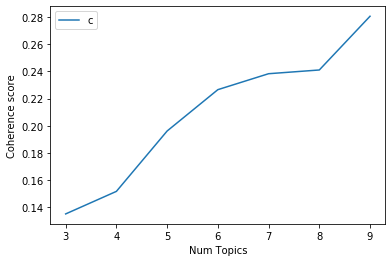

In [19]:
import matplotlib.pyplot as plt

mallet_coh_val = [coh for model, coh, topic in mallet_noun_models]

x = range(3, 10)
plt.plot(x, mallet_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Mallet LDA Model - topics
for model in mallet_noun_models:
    print("Model #{} Coherence Score: {}".format(model[2], model[1]))
    topics = model[0].show_topics(formatted=False)
    for topic, word_list in topics:
        topic_num = topic + 1
        result_list = []
        for word, word_prob in word_list:
            result_list.append(word)
        print("Topic {}: {}".format(topic_num, ', '.join(result_list)))
    print('----------------------------------------------------------------------------')

Model #3 Coherence Score: 0.13504950769824028
Topic 1: camera, screen, quality, performance, display, size, design, note, edge, sound
Topic 2: battery, life, card, apps, sim, time, memory, work, backup, ram
Topic 3: price, product, problem, money, device, time, issue, service, range, experience
----------------------------------------------------------------------------
Model #4 Coherence Score: 0.151656264357471
Topic 1: camera, quality, card, apps, display, sim, memory, sound, ram, speed
Topic 2: battery, life, problem, device, performance, issue, note, backup, experience, software
Topic 3: screen, price, product, size, design, edge, case, range, bit, hand
Topic 4: time, product, money, service, charger, work, cell, purchase, week, box
----------------------------------------------------------------------------
Model #5 Coherence Score: 0.19612552339775974
Topic 1: camera, quality, apps, display, memory, sound, ram, speed, call, processor
Topic 2: price, product, money, range, softwa

## Storing/Opening pickle file for the model

In [31]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
#pickle.dump(mallet_noun_models, open("mallet_noun_models_2000iter.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
mallet_noun_models = pickle.load(open("C:/TextAnalytics/GroupProject/Pickle Files/mallet_noun_models_2000iter.pkl", "rb"))

# Step 3: Topic Distribution
##### write any notes u want here

In [32]:
# check that pickle file was loaded correctly
mallet_noun_models

[[<gensim.models.wrappers.ldamallet.LdaMallet at 0x1830bbf3be0>,
  0.14282093402685905,
  3],
  0.1484142290252357,
  4],
  0.18501731009979944,
  5],
  0.23354987419530035,
  6],
  0.22870179172703772,
  7],
  0.22734088702261412,
  8],
  0.26214836812524556,
  9]]

In [33]:
import numpy as np
import pandas as pd

In [34]:
def doc_topic_distribution(model, corpus, data):
    
    sent_topics_df = pd.DataFrame()
    topic_dist = model[corpus]
    topic_removed = [1, 4, 6]
    
    for i, topics in enumerate(topic_dist):
        topics = sorted(topics, key=lambda x:(x[1]), reverse=True)
        # To get dominant topic only
        dom_topic = topics[0]
        sent_topics_df = sent_topics_df.append(pd.Series([int(dom_topic[0]), round(dom_topic[1], 4)]), ignore_index=True)
        
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.head()
    sent_topics_df.columns = ['Dominant Topic', 'Perc_Contribution', 'Sentence Tags']
    
    return sent_topics_df

In [35]:
dominant_topic_df = doc_topic_distribution(mallet_noun_models[5][0], sentence_vecs, sentence_tags)
dominant_topic_df.head()

,Dominant Topic,Perc_Contribution,Sentence Tags
0,1.0,0.1713,"[diehard, fan, series, upgrade]"
1,1.0,0.1422,[device]
2,5.0,0.1587,"[battery, life]"
3,1.0,0.1422,[feel]
4,3.0,0.1400,[heft]


In [68]:
sentences_list = sentences_df['sentence'].values
dominant_topic_df['sentence'] = sentences_list

pd.set_option("display.max_colwidth",  999)
dominant_topic_df.sample(20)

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence
670067,5.0,0.1587,"[battery, life]",This phone for me has an on-average battery life of 8 hours when I barely use it and is extremely laggy
570595,0.0,0.1394,"[inch, one]","Unlike 4 inch phones which i find difficult to type, i feel comfortable on this one"
711468,2.0,0.1394,"[tin, bill]",Excellent phone does exactly what it says on the tin - if you are looking for a phone minus the bells and whistels the 1280 fits the bill
479183,5.0,0.1422,[battery],great easy to use phone with a big battery
124865,7.0,0.1400,[soo],"Excellent phone,really i like soo much"
498302,1.0,0.1394,"[screen, power]","4 screen, 3000mah power, 2"
52738,3.0,0.1422,[functionality],This is great phone because of looks as well as functionality
414186,7.0,0.1334,[product],Very good product
409619,0.0,0.1368,"[space, dash, xl]","This does not have 4GB of space ore like 978MB, never accepted any calls, would recommend the Dash XL"
110970,1.0,0.1394,"[defect, replacement]",It was defective However i found the defect in 5 days therefore i am getting free replacement


In [67]:
dominant_topic_df.groupby('Dominant Topic').count().reset_index()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence
0,0.0,160725,160725,160725
1,1.0,175436,175436,175436
2,2.0,78954,78954,78954
3,3.0,91249,91249,91249
4,4.0,52001,52001,52001
5,5.0,72514,72514,72514
6,6.0,67719,67719,67719
7,7.0,49439,49439,49439


In [73]:
dominant_topic_df["phone_model"]=cleaned_df["phone_model"]
dominant_topic_df.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8


In [74]:
dominant_topic_df.shape

(748037, 5)

## Storing/Opening pickle file for the data frame

In [76]:
import pickle 

###@@@@@@@@@ THIS IS TO ***SAVE*** THE MODELS FROM ABOVE @@@@@@@@@###
pickle.dump(dominant_topic_df, open("dominant_topic_df_v2.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE MODELS FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#mallet_noun_models = pickle.load(open("C:/TextAnalytics/GroupProject/Pickle Files/dominant_topic_df_v1.pkl", "rb"))

# Step 4: Sentiment Analysis
##### write any notes u want here

In [81]:
#Takes in the sentence column from sentence_df, returns a list of polarity scores.
#Arg input 0 for Vader, 1 for TextBlob

def sa_score(name_df,arg_num):
    scores =[]
    
    if arg_num == 0:
        try:
            for sentence_value in name_df['sentence']:
                score = analyser.polarity_scores(sentence_value)
                scores.append(score)
        except Exception as e:
            print(str(e))
    else:        
        for sentence_value in name_df['sentence']:
            tb = TextBlob(sentence_value)
            scores.append(tb.sentiment.polarity)
    
    return scores
    

In [78]:
def normalised(name_df,col_name):

    """
    x_2 = df_values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_2_scaled = min_max_scaler.fit_transform(x_2)
    return pd.DataFrame(x_2_scaled)
    """
    new_compound = []
    for sentence_value in name_df[col_name]:
        norm_value = (sentence_value+1)/2
        new_compound.append(norm_value)
    
    name_df.drop([col_name], axis=1, inplace = True)
    name_df[col_name] = new_compound
    
    return name_df
    

## VADER

In [82]:
analyser = SentimentIntensityAnalyzer()
vader_scores = sa_score(dominant_topic_df,0)
vader_sentencesScores = pd.concat([dominant_topic_df,pd.DataFrame(vader_scores)],axis =1, sort = False)
vader_sentencesScores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,compound,neg,neu,pos
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.6486,0.000,0.813,0.187
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.0772,0.111,0.766,0.123
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.5859,0.000,0.513,0.487
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.2263,0.000,0.345,0.655
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.4215,0.000,0.263,0.737


In [83]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE VADER DF FROM ABOVE @@@@@@@@@###
pickle.dump(vader_sentencesScores, open("VaderSentencesScores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE VADER DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#vader_sentencesScores = pickle.load(open("VaderSentencesScores.pkl", "rb"))

## TextBlob

In [84]:
textblob_sentences = sa_score(dominant_topic_df,1)
textblob_sentencesScores = pd.concat([dominant_topic_df,pd.DataFrame(textblob_sentences)],axis =1, sort = False)

In [85]:
textblob_sentencesScores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,0
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.300000
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.000000
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.600000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.333333
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.600000


In [86]:
textblob_sentencesScores.rename(columns={0: 'compound'}, inplace=True)
textblob_sentencesScores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.300000
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.000000
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.600000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.333333
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.600000


In [87]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE TextBlob DF FROM ABOVE @@@@@@@@@###
pickle.dump(textblob_sentencesScores, open("TextBlobSentencesScores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE TextBlob DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#textblob_sentencesScores = pickle.load(open("TextBlobSentencesScores.pkl", "rb"))

## Putting both models into the same DF for rescaling scores and removing neutral scores

In [88]:
vader_sentencesScores.shape

(748037, 9)

In [89]:
textblob_sentencesScores.shape

(748037, 6)

In [90]:
vader_sentencesScores.drop(["neg","neu","pos"], axis=1, inplace = True)
vader_sentencesScores.rename(columns={'compound': 'Vader_compound'}, inplace=True)
textblob_sentencesScores.rename(columns={'compound': 'tb_compound'}, inplace=True)

In [91]:
df_normalised_scores=vader_sentencesScores.copy(deep = True)

In [92]:
df_normalised_scores["tb_compound"]=textblob_sentencesScores["tb_compound"]
df_normalised_scores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,Vader_compound,tb_compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.6486,0.300000
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.0772,0.000000
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.5859,0.600000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.2263,0.333333
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.4215,0.600000


In [93]:
#Scaling sentiment scores from '-1 to 1' to '0 to 1'
df_normalised_scores = normalised(df_normalised_scores,"Vader_compound")
df_normalised_scores = normalised(df_normalised_scores,"tb_compound")
df_normalised_scores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,Vader_compound,tb_compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.82430,0.650000
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.53860,0.500000
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.79295,0.800000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.61315,0.666667
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.71075,0.800000


In [94]:
comb_normalised_col = []
vader_neutral = []
tb_neutral = []
comb_neutral = []

for index, row in df_normalised_scores.iterrows():
    vader = row['Vader_compound']
    tb = row['tb_compound']
    comb = (vader+tb)/2
    comb_normalised_col.append(comb)
    #index =row['Index_Scores']
    
    vader = round(vader,2)
    tb = round(tb,2)
    comb = round(comb,2)  
    
    vader_bool= (vader<(2/3) and vader>=(1/3))
    tb_bool= (tb<(2/3) and tb>=(1/3))
    comb_bool= (comb<(2/3) and comb>=(1/3))
    
    if (vader_bool):
        vader_neutral.append(1)
    else:vader_neutral.append(0)
    
    if (tb_bool):
        tb_neutral.append(1)
    else:tb_neutral.append(0)
    
    if (comb_bool):
        comb_neutral.append(1)
    else:comb_neutral.append(0)

In [95]:
df_normalised_scores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,Vader_compound,tb_compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.82430,0.650000
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.53860,0.500000
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.79295,0.800000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.61315,0.666667
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.71075,0.800000


In [96]:
df_normalised_scores.shape

(748037, 7)

In [97]:
df_normalised_scores.insert(loc=6, column='Vader_neutral', value=vader_neutral)
df_normalised_scores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,Vader_compound,Vader_neutral,tb_compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.82430,0,0.650000
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.53860,1,0.500000
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.79295,0,0.800000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.61315,1,0.666667
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.71075,0,0.800000


In [98]:
df_normalised_scores["tb_neutral"] = tb_neutral
df_normalised_scores["comb_compound"] = comb_normalised_col
df_normalised_scores["comb_neutral"] = comb_neutral
df_normalised_scores.head()

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,Vader_compound,Vader_neutral,tb_compound,tb_neutral,comb_compound,comb_neutral
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.82430,0,0.650000,1,0.737150,0
1,1.0,0.1422,[device],I am amazed at some of the reviews and think people may just have a defective device that needs to be replaced,Samsung Galaxy S8,0.53860,1,0.500000,1,0.519300,1
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.79295,0,0.800000,0,0.796475,0
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.61315,1,0.666667,0,0.639908,1
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.71075,0,0.800000,0,0.755375,0


In [113]:
###@@@@@@@@@ THIS IS TO ***SAVE*** THE normalised DF FROM ABOVE @@@@@@@@@###
pickle.dump(df_normalised_scores, open("df_normalised_scores.pkl", "wb"))

###@@@@@@@@@ THIS IS TO ***OPEN*** THE normalised DF FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#df_normalised_scores = pickle.load(open("df_normalised_scores.pkl", "rb"))#

## Sampling for manual review of sentiments

In [100]:
# note that the output from this code is not the copy that we conducted the sample review on.
# that was an older version of the workbook with a slightly different corpus size. 
sa_sample = df_normalised_scores.sample(n = 120, replace = False, random_state = 42)
sa_sample.to_csv(r'sa_sample.csv', index = False)

## Drop all neutrals

In [102]:
vader_no_neutrals = df_normalised_scores.copy(deep = True)
vader_no_neutrals.head()
vader_no_neutrals.drop(["tb_compound","tb_neutral","comb_compound","comb_neutral"],axis = 1, inplace = True)
vader_no_neutrals=vader_no_neutrals[vader_no_neutrals.Vader_neutral != 1]
vader_no_neutrals.drop(["Vader_neutral"], axis = 1, inplace=True)
vader_no_neutrals.head(50)

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,Vader_compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.82430
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.79295
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.71075
5,0.0,0.1394,"[processor, apps]",Processor's still sluggish for the few apps that I have installed,Samsung Galaxy S8,0.29905
7,7.0,0.1561,"[product, consumer, ability, product, release]","One of the reasons I've been a long Samsung (product) consumer, they're ability to impress me with each product release",Samsung Galaxy S8,0.81845
10,4.0,0.1394,"[bluetooth, trip]",Bluetooth on my 1st trip struggles to stay connected,Samsung Galaxy S8,0.31940
11,1.0,0.1400,[news],Good news,Samsung Galaxy S8,0.72020
12,5.0,0.1587,"[battery, life]",battery life is great and lots of great features,Samsung Galaxy S8,0.92405
18,0.0,0.1713,"[glass, screen, protector, nightmare]",I agree with all the other reviews stating that trying to use a glass screen protector with it is a nightmare,Samsung Galaxy S8,0.68060
19,3.0,0.1587,"[screen, screen]",I have so far has 2 different screen protectors on it and both times they have made it difficult for me to tap on the screen,Samsung Galaxy S8,0.31940


In [103]:
tb_no_neutrals = df_normalised_scores.copy(deep = True)
tb_no_neutrals.drop(["Vader_compound","Vader_neutral","comb_compound","comb_neutral"],axis = 1, inplace = True)
tb_no_neutrals=tb_no_neutrals[tb_no_neutrals.tb_neutral != 1]
tb_no_neutrals.drop(["tb_neutral"], axis = 1, inplace=True)
tb_no_neutrals.head(10)

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,tb_compound
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.800000
3,1.0,0.1422,[feel],Adequate feel,Samsung Galaxy S8,0.666667
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.800000
11,1.0,0.1400,[news],Good news,Samsung Galaxy S8,0.850000
12,5.0,0.1587,"[battery, life]",battery life is great and lots of great features,Samsung Galaxy S8,0.900000
14,3.0,0.1394,"[time, sense]",I got the S7 because at the time the fries made the most sense for me,Samsung Galaxy S8,0.750000
20,0.0,0.1422,"[apps, look]","Great apps, great look",Samsung Galaxy S8,0.900000
24,0.0,0.1431,"[lack, support, design]",Won't buy another Samsung based on their lack of support for a poor design,Samsung Galaxy S8,0.300000
25,2.0,0.1422,"[camera, use]","Great phone with a PHENOMENAL Camera, not all that hard to get use to",Samsung Galaxy S8,0.668056
30,7.0,0.1557,"[week, release, date]","this arrived a week before it's release date, very happy with it",Samsung Galaxy S8,1.000000


In [104]:
comb_no_neutrals = df_normalised_scores.copy(deep = True)
comb_no_neutrals.drop(["Vader_compound","Vader_neutral","tb_compound","tb_neutral"],axis = 1, inplace = True)
comb_no_neutrals=comb_no_neutrals[comb_no_neutrals.comb_neutral != 1]
comb_no_neutrals.drop(["comb_neutral"], axis = 1, inplace=True)
comb_no_neutrals.head(30)

,Dominant Topic,Perc_Contribution,Sentence Tags,sentence,phone_model,comb_compound
0,1.0,0.1713,"[diehard, fan, series, upgrade]","As a diehard Samsung fan who has had every Samsung phone since before the S series started, this has been my favorite upgrade so far",Samsung Galaxy S8,0.737150
2,5.0,0.1587,"[battery, life]",The battery life is amazing,Samsung Galaxy S8,0.796475
4,3.0,0.1400,[heft],Nice heft,Samsung Galaxy S8,0.755375
11,1.0,0.1400,[news],Good news,Samsung Galaxy S8,0.785100
12,5.0,0.1587,"[battery, life]",battery life is great and lots of great features,Samsung Galaxy S8,0.912025
20,0.0,0.1422,"[apps, look]","Great apps, great look",Samsung Galaxy S8,0.912025
21,5.0,0.1394,"[durability, egg]","BUT, the durability is that of a fresh egg",Samsung Galaxy S8,0.687425
24,0.0,0.1431,"[lack, support, design]",Won't buy another Samsung based on their lack of support for a poor design,Samsung Galaxy S8,0.299525
25,2.0,0.1422,"[camera, use]","Great phone with a PHENOMENAL Camera, not all that hard to get use to",Samsung Galaxy S8,0.748853
28,1.0,0.1394,"[screen, edge]","6"" screen, it just looks bigger cus it's not as wide as my S7 Edge, takes amazing pictures",Samsung Galaxy S8,0.688142


In [115]:
#Workaround for phone model appearing as null in front-end
vader_phone_values=vader_no_neutrals["phone_model"].values
tb_phone_values=tb_no_neutrals["phone_model"].values
comb_phone_values=comb_no_neutrals["phone_model"].values

In [116]:
vader_no_neutrals["phone_model"]=vader_phone_values
tb_no_neutrals["phone_model"]=tb_phone_values
comb_no_neutrals["phone_model"]=comb_phone_values

In [117]:
vader_no_neutrals.shape

(421704, 6)

In [118]:
tb_no_neutrals.shape

(302274, 6)

In [119]:
comb_no_neutrals.shape

(332675, 6)

In [120]:
###@@@@@@@@@ THIS IS TO ***SAVE*** the DFs without neutrals FROM ABOVE @@@@@@@@@###
pickle.dump(vader_no_neutrals, open("vader_no_neutrals.pkl", "wb"))
pickle.dump(tb_no_neutrals, open("tb_no_neutrals.pkl", "wb"))
pickle.dump(comb_no_neutrals, open("comb_no_neutrals.pkl", "wb"))

#Saving as CSV
vader_no_neutrals.to_csv(r'vader_no_neutrals.csv', index = False)
tb_no_neutrals.to_csv(r'tb_no_neutrals.csv', index = False)
comb_no_neutrals.to_csv(r'comb_no_neutrals.csv', index = False)

###@@@@@@@@@ THIS IS TO ***OPEN*** THE DFs FROM THE STORED PICKLE FILE @@@@@@@@@###
### CHECKPOINT - can just load the pickle file and start running your analysis
#vader_no_neutrals = pickle.load(open("vader_no_neutrals.pkl", "rb"))#
#tb_no_neutrals = pickle.load(open("tb_no_neutrals.pkl", "rb"))#
#comb_no_neutrals = pickle.load(open("comb_no_neutrals.pkl", "rb"))#

In [112]:
vader_no_neutrals.shape

(421704, 6)

In [107]:
tb_no_neutrals.shape

(302274, 6)

In [108]:
comb_no_neutrals.shape

(332675, 6)